# Defining Cell Type Based on Marker Gene Expression

Eliza Duvall <br>
BIOF509 Final Project <br>
December 13, 2018 <br>

### Documentation

<b>Background:</b> Recent work demonstrating lost or impaired beta cells in diabetes can be replaced with insulin-producing cells, generated from renewable sources such as embryonic stem cells has sparked great excitement. However, the molecular and cellular processes leading to beta cell differentiation are not well understood. Single cell technologies hold the promise to address these challenges and acceleratethe study of organ development and regenerative medicine approaches to replace damaged or diseased organs. 

<b>Data:</b> Single-cell RNA-Seq data with the transcriptomes of 495 embryonic mouse pancreatic cells (E15) and 23,000 genes.

<b>Goal:</b> Before studying the gene expression changes for each cell type, we must determine the cell type. The goal of this notebook is to cluster cells into various clusters with similar gene expression. Each cluster will then be classified into cell types, duct, progenitor, or hormone, based on the marker gene expression of each cell type, Cpa1, Neurog3, and Chga, respectively.

<b>Methods:</b> <br> 
(1) Normalize the data (TPM) <br>
(2) Reduce the data (T-SNE) <br>
(3) Run elbow silhouette to determine number of clusters <br>
(4) Plot the TSNE graph with colors representing different clusters <br>
(5) Define cell clusters based on marker genes <br>


In [1]:
# import all necessary files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn import metrics

In [2]:
# Import the raw data:
# This is called a "counts table"
# The table represents the number of RNA transcripts of 23,000 genes in 495 cells. 

counts = pd.read_table("EA_Ngn3_160701.csv", sep="\t")
counts.head()

,H2.EA01.Ngn3.ki.1.,B10.EA02.Ngn3.ki.1.,B9.EA01.Ngn3.ki.1.,H1.EA01.Ngn3.ki.1.,E5.EA02.Ngn3.ki.1.,G12.EA04.Ngn3.ki.1.,E7.EA01.Ngn3.ki.1.,A4.EA02.Ngn3.ki.1.,F11.EA03.Ngn3.ki.1.,C12.EA03.Ngn3.ki.1.,...,D12.EA07.Ngn3.ki.1.1,B10.EA06.Ngn3.ki.1.1,A1.EA07.Ngn3.ki.1.1,F7.EA05.Ngn3.ki.1.1,F2.EA06.Ngn3.ki.1.1,H4.EA07.Ngn3.ki.1.1,F5.EA07.Ngn3.ki.1.1,B1.EA06.Ngn3.ki.1.1,G1.EA05.Ngn3.ki.1.1,A6.EA07.Ngn3.ki.1.1
0610005C13Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610007C21Rik,235,114,337,125,202,0,588,0,0,225,...,446,0,79,174,0,0,520,257,90,516
0610007L01Rik,87,0,181,6,0,0,0,0,0,13,...,0,0,0,173,0,264,2,0,42,25
0610007N19Rik,58,0,22,0,0,39,0,0,0,0,...,0,0,0,85,0,0,0,0,0,0
0610007P08Rik,0,0,0,0,268,111,0,0,0,0,...,0,0,0,0,0,330,0,0,0,0


In [3]:
# Filter the data by removing genes with a row sum of 0
# The removed data represents genes that had zero RNA transcripts in all of the cells.

counts = counts.loc[(counts.sum(axis=1) != 0)]

# Look at the resulting size of the matrix
# Previously was (23002, 495)

counts.shape

(16678, 495)

In [4]:
# Pre-processing the data
# Normalize the dataframe by transcripts per million (TPM) 
# Purpose: to account for sequencing depth.

counts_norm = counts.transpose()
counts_norm = counts_norm/counts_norm.sum(axis=0)*1000000
counts_norm = counts_norm.transpose()
counts_norm = np.log2(counts_norm + 1)

# Transpose the dataframe

counts_norm_T = counts_norm.transpose()

# View the top 5 lines of the normalized data

counts_norm_T.head()

,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,...,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
H2.EA01.Ngn3.ki.1.,11.551657,12.202547,14.732288,0.000000,0.000000,11.949530,9.738004,9.671121,0.0,0.000000,...,11.289492,0.0,11.344408,0.0,7.270508,0.000000,0.0,0.000000,0.0,0.0
B10.EA02.Ngn3.ki.1.,10.508540,0.000000,0.000000,0.000000,6.291448,8.417338,10.702414,10.770977,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,13.350058,0.0,0.000000,0.0,0.0
B9.EA01.Ngn3.ki.1.,12.071600,13.259290,13.333825,0.000000,0.000000,13.973917,6.361648,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,14.846145,13.699178,0.0,13.129536,0.0,0.0
H1.EA01.Ngn3.ki.1.,10.641347,8.348692,0.000000,0.000000,12.501978,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
E5.EA02.Ngn3.ki.1.,11.333430,0.000000,0.000000,14.874716,0.000000,0.000000,12.791283,10.602260,0.0,9.984808,...,0.000000,0.0,0.000000,0.0,15.364456,0.000000,0.0,12.327985,0.0,0.0


In [5]:
# Reduce the number of dimensions
# Use the manifold learning method, TSNE
# TSNE is best to find a non-linear structure and for unsupervised problems.

# Input: The normalized counts matrix
# Output: The remaining, reduce number of features will represent the original data's structure

counts_TSNE = TSNE(n_components=2, perplexity=20).fit_transform(counts_norm_T)

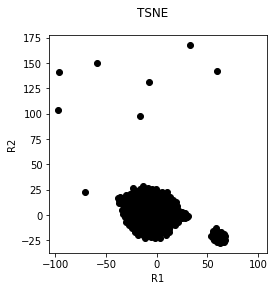

In [6]:
# Visualize the shape of the data with reduce dimensions from TSNE
# Do this by creating a function named "scatterplot_2D"

# Input: the matrix reduced after applying TSNE
# Output: a scatterplot  

def scatterplot_2D(R, title, labels=None):
    assert(R.shape[1] == 2)
    if labels is None:
        c = 'black'
    else:
        color_scale = np.linspace(0, 1, len(set(labels)))
        c = [plt.cm.Set1(color_scale[i]) for i in labels]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('white')
    ax.scatter(R[...,0], R[...,1], color=c)
    ax.axis('square')
    ax.set_xlabel('R1')
    ax.set_ylabel('R2')
    fig.suptitle(title)
    plt.show()

scatterplot_2D(counts_TSNE, 'TSNE')

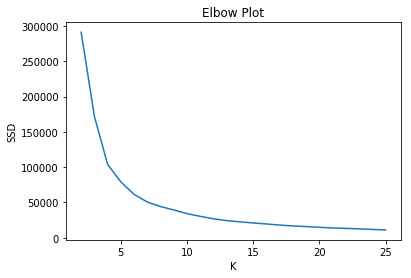

In [7]:
# Before using k-means clustering of the sample, first determine the number of clusters
# Do so by using the elbow silhouette. 

# Create a function called plot_elbow
# Input: Counts table after reducing the dimensions using TSNE
# Output: Elbow plot explaing the variance captured for each number of clusters (k)

def plot_elbow(dataset):
    inertias = []
    for i in range(2,26):
        kmeans = KMeans(n_clusters=i, random_state=126)
        kmeans.fit(dataset)
        inertias.append(kmeans.inertia_)

    plt.plot(range(2,26), inertias)
    plt.title("Elbow Plot")
    plt.xlabel("K")
    plt.ylabel("SSD")
    
    return inertias

#plot_elbow(counts_TSNE)

ssds = plot_elbow(counts_TSNE)


In [8]:
# From the plot above, the optimal number of clusters for this dataset is 6

# Input: Counts table after reducing the dimensions using TSNE and transposition
# Output: a vector of the cluster assignments, ranging from 1 to 8, for each cell

model = KMeans(
    n_clusters=6,
    init="random", 
    n_init=10, 
    max_iter=300,)

model.fit(counts_norm_T)
cluster_labels = model.predict(counts_norm_T)

# See the vector of cluster assignments for each cell

print(cluster_labels)

[5 3 3 3 1 3 1 3 3 1 1 3 0 3 5 1 3 1 3 5 3 3 3 0 1 5 3 0 3 3 5 3 3 0 5 5 1
 3 1 0 1 3 1 1 5 3 0 3 3 3 5 5 3 0 3 1 0 3 0 3 3 1 3 0 1 3 3 0 5 0 3 3 1 0
 5 3 0 1 3 5 1 5 0 3 3 0 1 1 5 5 1 1 1 3 3 3 3 3 3 5 1 3 3 0 3 3 1 3 3 0 1
 1 3 0 3 1 3 3 3 5 5 5 3 1 0 0 0 3 3 5 3 3 3 1 3 1 5 1 1 5 3 0 1 0 3 0 3 3
 3 3 0 5 0 3 3 3 0 0 1 3 3 1 3 1 3 1 0 1 3 1 0 3 3 3 1 5 3 3 3 1 3 3 5 3 3
 3 3 1 1 3 3 0 3 0 3 3 0 1 1 1 1 0 3 3 0 3 3 3 0 3 3 3 3 3 5 3 3 1 1 3 0 3
 3 0 0 3 3 0 5 0 3 3 3 3 5 3 1 0 0 0 3 5 3 0 0 3 0 0 3 5 1 0 5 0 3 5 3 3 0
 3 0 1 3 5 1 3 3 3 3 0 5 3 3 3 3 3 1 3 0 3 5 5 1 1 1 1 1 1 2 2 5 1 1 1 1 2
 1 2 5 1 2 1 3 1 1 1 3 2 2 3 5 4 2 1 1 1 1 2 5 1 1 1 5 3 2 2 5 5 3 4 3 1 5
 1 1 2 2 2 5 1 1 1 5 5 1 1 1 1 1 1 5 1 1 2 1 2 5 5 1 0 2 1 3 2 3 1 5 2 1 1
 2 2 1 2 5 1 1 1 5 1 1 3 2 1 1 1 2 5 1 5 3 5 2 1 3 1 1 2 2 3 1 2 3 2 1 4 2
 2 1 3 2 5 2 1 2 1 5 3 3 1 2 1 2 5 1 1 5 1 2 1 2 2 5 2 2 2 1 2 1 2 2 1 1 2
 1 2 2 5 5 5 1 5 5 5 5 2 3 2 2 1 1 5 1 1 3 3 2 1 1 5 3 0 1 2 1 1 1 5 2 2 5
 1 5 4 1 4 1 4 5 1 0 2 3 

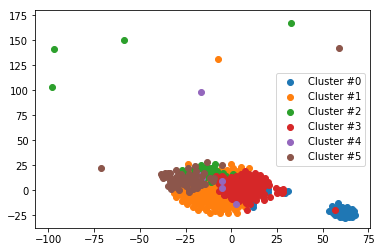

In [9]:
# Create a function called "plot_kmeans" 
# plot_kmeas will help visualize the clusters

def plot_kmeans(original_data, cluster_labels, model, k):
    for cluster_idx in range(k):
        plt.scatter(
            original_data.iloc[cluster_labels == cluster_idx, 0],
            original_data.iloc[cluster_labels == cluster_idx, 1],
            label="Cluster #{}".format(cluster_idx),)
    plt.legend()

# Visualize the data using the plot_kmeans function
# Input: the counts_TSNE variable as a matrix and the vector of cluster labels for each cell
# Output: a graphical representation of k-means clustering

plot_kmeans(pd.DataFrame(counts_TSNE), cluster_labels, model, 6)

In [10]:
# Determine which cell types are clustered together
counts_norm_T["Cluster"] = cluster_labels
clust0 = counts_norm_T.loc[counts_norm_T["Cluster"] == 0]
clust1 = counts_norm_T.loc[counts_norm_T["Cluster"] == 1]
clust2 = counts_norm_T.loc[counts_norm_T["Cluster"] == 2]
clust3 = counts_norm_T.loc[counts_norm_T["Cluster"] == 3]
clust4 = counts_norm_T.loc[counts_norm_T["Cluster"] == 4]
clust5 = counts_norm_T.loc[counts_norm_T["Cluster"] == 5]

# Create a table of the three primary cell types
# Cells transition from duct to progenitor to hormone cells
# Each row is a different cluster and each column is the mean expression of the marker genes

table = {"Cluster": [0, 1, 2, 3, 4, 5],
         "Duct": [clust0["Cpa1"].mean(), clust1["Cpa1"].mean(), clust2["Cpa1"].mean(), clust3["Cpa1"].mean(), clust4["Cpa1"].mean(), clust5["Cpa1"].mean()],
         "Progenitor": [clust0["Neurog3"].mean(), clust1["Neurog3"].mean(), clust2["Neurog3"].mean(), clust3["Neurog3"].mean(), clust4["Neurog3"].mean(), clust5["Neurog3"].mean()],
         "Hormone": [clust0["Chga"].mean(), clust1["Chga"].mean(), clust2["Chga"].mean(), clust3["Chga"].mean(), clust4["Chga"].mean(), clust5["Chga"].mean(),],
        }
table = pd.DataFrame(table)
table

,Cluster,Duct,Progenitor,Hormone
0,0,10.180521,0.837060,0.219164
1,1,0.270596,2.183546,7.722696
2,2,0.351803,7.113197,11.242804
3,3,0.375517,9.894445,3.505667
4,4,0.000000,8.045830,13.581404
5,5,0.373908,0.613456,9.042749


### From the table above, we can conclude the following: <br>

<b>Cluster 0:</b> Cluster 0 is primarily composed of duct cells due to it's high mean expression of the duct marker gene, Cpa1. <br>
<br>
<b>Cluster 1:</b> Cluster 1 is primarily composed of hormone cells due to it's high mean expression of the hormone marker gene, Chga. <br>
<br>
<b>Cluster 2:</b> Cluster 2 is primarily composed of hormone cells, due to the high mean expression of the hormone marker gene, Chga. It is also likely that either some progenitor cells reside in cluster 1, or some cells have started it's transition to hormone cells by expressing Chga.<br>
<br>
<b>Cluster 3:</b> Cluster 3 is primarily composed of progenitor cells due to it's high mean expression of the progenitor marker gene, Neurog3<br> 
<br>
<b>Cluster 4:</b> Cluster 4 is primarily composed of hormone cells. Similar to cluster 2, cluster 4 likely holds either some progenitor cells or some cells ending it's transition between progenitor cells and hormones. <br>
<br>
<b>Cluster 5:</b> Cluster 5 is primarily composed of hormone cells due to it's high mean expression of the hormone marker gene, Chga. <br>
<br>